In [1]:
import pandas as pd
import numpy as np
import json
import datetime
import re

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob

pd.options.display.max_rows = 200

sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load raw data

### 1a. comments

In [2]:
df = pd.read_json('/gh/data/personal-data-requests/facebook/comments/comments.json')
df.loc[0, 'comments']

{'timestamp': 1564021887,
 'data': [{'comment': {'timestamp': 1564021887,
    'comment': 'good call. hm. yeah, I wonder how we could get a measure of "severity". That would be cool. I\'m hoping to do some text analysis with this data at a later point too. So could start exploring it then. We could set up a Google Collaboratory notebook to explore together!\n(in the meantime, just got my personal data from Tinder so exploring that depressing data ð\x9f\x98\x82 along with the rest of r/dataisbeautiful)',
    'author': 'Scott Cole'}}],
 'title': "Scott Cole replied to Alex Vickers's comment."}

In [3]:
jp = '/gh/data/personal-data-requests/facebook/comments/comments.json'
with open(jp) as file:
    data = json.load(file)
df_comments = pd.DataFrame(data['comments'])
df_comments['comment'] = [x[0]['comment']['comment'] if x is not np.nan else np.nan for x in df_comments['data']]
cols_keep = ['timestamp', 'title', 'comment']
df_comments = df_comments[cols_keep]
df_comments.loc[[322]]

,timestamp,title,comment
322,1466517685,Scott Cole commented on Matteo D'Antonio's post.,I'll be there


### 1b. Events

In [4]:
jp = '/gh/data/personal-data-requests/facebook/events/your_event_responses.json'
import json
with open(jp) as file:
    data = json.load(file)
df_events = []
for k,v in data['event_responses'].items():
    df_temp = pd.DataFrame(v)
    df_temp['type'] = k
    df_events.append(df_temp)
df_events = pd.concat(df_events).reset_index(drop=True)
cols_keep = ['start_timestamp', 'end_timestamp', 'type', 'name']
df_events = df_events[cols_keep]
df_events.loc[[95]]

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


,start_timestamp,end_timestamp,type,name
95,1289957400,1289964600,events_declined,Harry Potter Trivia Night


### 1c. friends

In [5]:
jp = '/gh/data/personal-data-requests/facebook/friends/friends.json'
import json
with open(jp) as file:
    data = json.load(file)
df_friends = pd.DataFrame(data['friends']).drop('contact_info', axis=1)
df_friends.loc[[len(df_friends)-1]]

,name,timestamp
711,Josh Patel,1188509673


In [6]:
pd.Series([x.split(' ')[0] for x in df_friends['name']]).value_counts()[:10]

Chris      9
Lauren     7
Alex       7
Tyler      7
Ryan       7
Stephen    7
Andrew     6
Rachel     6
Kyle       6
Daniel     6
dtype: int64

### 1d. Likes

In [7]:
jp = '/gh/data/personal-data-requests/facebook/likes_and_reactions/posts_and_comments.json'
import json
with open(jp) as file:
    data = json.load(file)
df_likes = pd.DataFrame(data['reactions']).drop('attachments', axis=1)
df_likes['reaction_type'] = [x[0]['reaction']['reaction'] for x in df_likes['data']]
df_likes.drop('data', axis=1, inplace=True)
df_likes.loc[[4]]

,timestamp,title,reaction_type
4,1564798723,Scott Cole likes Ian Hale's post.,LIKE


In [8]:
df_likes['reaction_type'].value_counts()

LIKE     4301
HAHA       48
LOVE       35
SORRY      30
ANGER      14
WOW         5
Name: reaction_type, dtype: int64

### 1e. location

In [9]:
jp = '/gh/data/personal-data-requests/facebook/location/location_history.json'
import json
with open(jp) as file:
    data = json.load(file)
df_loc = pd.DataFrame(data['location_history']).rename(columns={'creation_timestamp': 'ts'})
df_loc['latitude'] = [x['latitude'] for x in df_loc['coordinate']]
df_loc['longitude'] = [x['longitude'] for x in df_loc['coordinate']]
df_loc.drop('coordinate', axis=1, inplace=True)
df_loc.loc[[4258]]

,ts,name,latitude,longitude
4258,1477679141,Carlsbad,33.16043,-117.34948


### 1f. messages

In [10]:
messenger_name = 'AlexVickers_374yFHL9yw'
jp = '/gh/data/personal-data-requests/facebook/messages/inbox/{}/message_1.json'.format(messenger_name)
import json
with open(jp) as file:
    data = json.load(file)
df_messages_alex = pd.DataFrame(data['messages'])
df_messages_alex.loc[[518]]

,content,photos,reactions,sender_name,share,sticker,timestamp_ms,type
518,I'm interested to see how soon it will be unti...,NaN,NaN,Scott Cole,NaN,NaN,1400624708631,Generic


### 1g. posts

In [11]:
jp = '/gh/data/personal-data-requests/facebook/posts/your_posts_1.json'
import json
with open(jp) as file:
    data = json.load(file)
df_posts = pd.DataFrame(data)
df_posts.loc[[0]]

,attachments,data,tags,timestamp,title
0,[{'data': [{'media': {'uri': 'photos_and_video...,[{'post': 'Fun exploration of Politifact check...,NaN,1563657751,NaN


# 2. Analyze likes

### 2a. Most liked authors and groups

In [12]:
reactions = ['likes', 'liked', 'reacted to']
possible_objects = ['post', 'photo', 'comment', 'video', 'link', 'album', 'life event', 'friendship', 'GIF']

splits = '|'.join(possible_objects + reactions)
titles_split = [re.split(splits, x) for x in df_likes['title']]
authors = [x[1].strip().replace("'s", '') for x in titles_split]
authors_counts = pd.Series(authors).value_counts()

groups_of_posts = [x[2].replace(' in ', '').replace('.', '').strip() for x in titles_split]
groups_counts = pd.Series(groups_of_posts).value_counts()

all_counts = pd.Series(authors + groups_of_posts).value_counts()

# Likes over time
* Meme vs post
* High school friends. College friends. Grad school friends. Spongebob memes. Meme pages. Meme groups
* Note having just 2 categories is very over-simplifying and makes errors

In [13]:
# Define strings indicative of memes
groups_keep = ['Subtle Depressed People Traits', 'is mayonnaise an instrument',
               'SDPT Dating and Friends', 'Anxiety & Depression Memes',
               'subtle asian traits']
pages_keep = ['Disturbing Quotes', 'SDPT Confessions', 'Nihilist Memes', 'I See What You Did There']

meme_strs = groups_keep + pages_keep
df_likes['is_meme'] = [any(x in title for x in meme_strs) for title in df_likes['title']]
df_likes['dt'] = pd.to_datetime(df_likes['timestamp'],unit='s')
df_likes['month_year'] = df_likes['dt'].dt.round('d') + pd.offsets.MonthEnd(0)

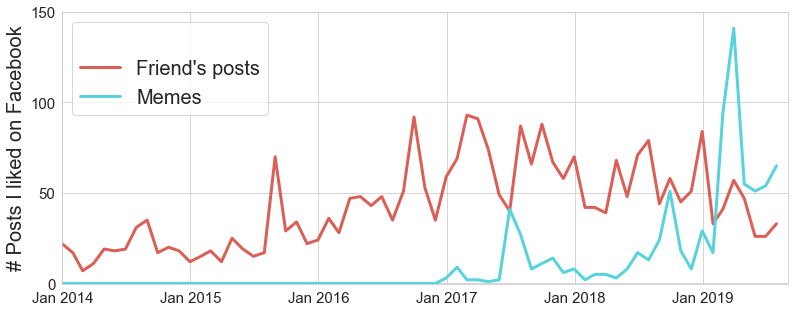

In [14]:
df_plt = df_likes.groupby(['month_year', 'is_meme'])['dt'].count().reset_index().rename(columns={'dt': 'count'})
df_plt = df_plt.pivot(index='month_year', columns='is_meme', values='count').fillna(0)
df_plt = df_plt.reindex(pd.date_range('2009-06-01', '2019-08-01', freq='M')).fillna(0).stack().reset_index()
df_plt = df_plt.rename(columns={'level_0': 'date', 'artistName': 'artist', 0: 'count'})
df_plt['liked'] = df_plt['is_meme'].map({True: 'Memes', False: "Friend's posts"})

plt.figure(figsize=(13,5))

sns.lineplot(x='date', y='count', data=df_plt, hue='liked', linewidth=3,
             palette=sns.color_palette('hls', n_colors=2)
            )
plt.xticks([datetime.datetime(x, 1, 1) for x in range(2009,2021)])
plt.xlim(datetime.datetime(2014, 1, 1), datetime.datetime(2019, 9, 1))
plt.ylim((-.2,150))
plt.yticks(np.arange(0,151,50))
plt.xticks([datetime.datetime(x, 1, 1) for x in np.arange(2014,2020)],
           ['Jan {}'.format(x) for x in np.arange(2014,2020)])
plt.xlabel('')
plt.ylabel('# Posts I liked on Facebook')

# # Format legend
leg = plt.legend(fontsize=20, loc='upper left')
leg.texts[0].set_text(None)
for line in leg.get_lines():
    line.set_linewidth(3)
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/facebook_meme_likes_temporal.png')